In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import math

In [65]:
class volatility_surface(object):
    
    
    def __init__(self,S,K,T,r,std,q=None,option=None):
        
        self.S=S
        self.K=K
        self.T=T
        self.r=r
        self.std=std
        self.q=q
        self.option=option
        

        
    def get_d1_d2(self):
        if self.q==None:
            d1=(np.log(self.S/self.K)+(self.r+self.std**2/2)*self.T)/(self.std*np.sqrt(self.T))
            d2=d1-self.std*np.sqrt(self.T)
        else:
            d1=(np.log(self.S/self.K)+(self.r-self.q+self.std**2/2)*self.T)/(self.std*np.sqrt(self.T))
            d2=d1-self.std*np.sqrt(self.T)
        return d1,d2       
    
    
        
    def eur_opt(self):
        
        d1=self.get_d1_d2()[0]
        d2=self.get_d1_d2()[1]
        
        
        c = self.S*stats.norm.cdf(d1, 0.0, 1.0)-self.K*np.exp(-self.r*self.T)*stats.norm.cdf(d2, 0.0, 1.0)
        p = self.K*np.exp(-self.r*self.T)*stats.norm.cdf(-d2, 0.0, 1.0)-self.S*stats.norm.cdf(-d1, 0.0, 1.0)
        if self.option == 'call':
            return np.maximum(0,c)
        elif self.option == 'put':
            return np.maximum(0,p)                


    def get_vega(self):
        d1=self.get_d1_d2()[0]
        d2=self.get_d1_d2()[1]
        phi= lambda x: np.exp((-x**2)/2)/np.sqrt(2*math.pi)
        if self.q==None:
            vega=self.S*phi(d1)*np.sqrt(self.T)
        else:
            vega=self.S*np.exp(-1*self.q*self.T)*phi(d1)*np.sqrt(self.T)
        return vega     
    
    
    def implied_vol(self,market_option):
        
        test_std=0.5
        iterations=0
        
        
        if volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).eur_opt()>float(market_option):
            while volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).eur_opt()>float(market_option):
                test_std-=0.001
                iterations+=1
                if volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).eur_opt()==float(market_option):
                    break
                #self.implied_volatility=test_std
        elif self.eur_opt()<float(market_option):
            while volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).eur_opt()<float(market_option):
                test_std+=0.001
                iterations+=1
                if volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).eur_opt()==float(market_option):
                    break   
                #self.implied_volatility=test_std
        return test_std,iterations
                
                
    
                
    def retrieve_call_put(self,market_option):
        
        #self.option=input("What is the option type ? Enter either 'call' or 'put'")
        if self.option == 'call':
            #self.option=call
            market_put=market_option+self.K*np.exp(-self.r*self.T)-self.S*np.exp(-self.r*self.T)
            return market_put
        elif self.option == 'put':
            #self.option=put
            market_call=market_option+self.S*np.exp(-self.r*self.T)-self.K*np.exp(-self.r*self.T)
            return market_call
        else :
            self.option=input("Unspecified type of option, please enter either 'call' or 'put':")
            while option not in ["call","put",'call','put']:
                self.option=input("Unspecified type of option, please enter either 'call' or 'put':")
            else:
                if self.option == 'call':
                    market_put=market_option+self.K*np.exp(-self.r*self.T)-self.S*np.exp(-self.r*self.T)
                    return market_put
                elif self.option == 'put':
                    market_call=market_option+self.S*np.exp(-self.r*self.T)-self.K*np.exp(-self.r*self.T)
                    return market_call
                
    
    def nr_iv(self, market_option,tol=None):
        
        iterations=0
        max_iterations = 500
        test_std = 0.5 #initial guess

     
        while volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).eur_opt()!=float(market_option) and iterations<max_iterations:
            bs_price = volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).eur_opt()
            Cprime =  volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).get_vega()*100
            C = bs_price - float(market_option)
            test_std = test_std - C/Cprime
            bs_new = volatility_surface(S=self.S,std=test_std,r=self.r,K=self.K,T=self.T,option=self.option,q=self.q).eur_opt()
            iterations+=1
        #if (abs(bs_new - market_option) < tol):
            #break

        implied_vol = test_std
        return implied_vol,iterations
                
                
    def vol_smile(self,market_option):
        
        test_std=0.5
        Strike=np.linspace(self.S*0.8,self.S*1.2,40)
        KS=[i/self.S for i in Strike]
        smile=[] 
        for k,ks in zip(Strike,KS):
            if ks<1:
                smile.append(volatility_surface(S=self.S,K=k,T=self.T,r=self.r,std=test_std,option="put").implied_vol(market_option=market_option)[0])
            else:
                smile.append(volatility_surface(S=self.S,K=k,T=self.T,r=self.r,std=test_std,option="call").implied_vol(market_option=market_option)[0])
        zipped=list(zip(Strike,KS,np.round(smile,3)))
        data=pd.DataFrame(zipped, columns=["Strike Price", "Strike/S", "Implied Volatility"])
        plt.plot(data["Strike Price"],data["Implied Volatility"])
        return smile,data
    
    
    
    def get_surface(self,market_option):

        TTM=np.linspace(0.25,5,20)
        Strike=np.linspace(self.S*0.8,1.2*self.S,40)
        KS=[i/self.S for i in Strike]
        df=pd.DataFrame()
        
        for t in TTM:
        
            df["{} years".format(t)]=volatility_surface(S=self.S,std=self.std,r=self.r,K=self.K,T=t,option=self.option,q=self.q).vol_smile(market_option=market_option)[0]
        
        
        
        x = KS
        y = TTM
  
        X, Y = np.meshgrid(x, y)
        Z = df.values.T
 
        fig = plt.figure(figsize =(14, 9))
        ax = plt.axes(projection ='3d')
 
        ax.plot_surface(X, Y, Z)
 
        plt.title("Implied volatility Surface")
        plt.show()

    
        return df



In [3]:
volatility_surface(S=95,K=85,T=0.5,r=0.1,std=0.25,option="call").eur_opt()

15.663826402455726

In [4]:
volatility_surface(S=95,K=85,T=0.5,r=0.1,std=0.25,option="call").get_vega()

16.247619632526177

In [16]:
volatility_surface(95,112.5,0.5,0.1,0.25,option="put").implied_vol(market_option=15)

(0.2639999999999998, 236)

In [17]:
volatility_surface(95,112.5,0.5,0.1,0.25,option="put").nr_iv(market_option=15)

(0.2661306259166026, 500)

In [5]:
volatility_surface(S=95,K=85,T=0.5,r=0.1,std=0.25,option="call").retrieve_call_put(11)

1.4877057549928594

([1.6829999999999252,
  1.6589999999999279,
  1.6339999999999306,
  1.6099999999999333,
  1.5869999999999358,
  1.5629999999999384,
  1.539999999999941,
  1.5169999999999435,
  1.493999999999946,
  1.4719999999999485,
  1.4499999999999509,
  1.4279999999999533,
  1.4059999999999557,
  1.384999999999958,
  1.3639999999999604,
  1.3419999999999628,
  1.321999999999965,
  1.3009999999999673,
  1.2799999999999696,
  1.2599999999999718,
  1.239999999999974,
  1.2199999999999762,
  1.1999999999999784,
  1.1799999999999806,
  1.1599999999999828,
  0.9660000000000004,
  0.9780000000000004,
  0.9890000000000004,
  1.0000000000000004,
  1.0109999999999992,
  1.021999999999998,
  1.0329999999999968,
  1.0429999999999957,
  1.0529999999999946,
  1.0629999999999935,
  1.0729999999999924,
  1.0829999999999913,
  1.0919999999999903,
  1.1019999999999892,
  1.1109999999999882,
  1.1199999999999872,
  1.1289999999999862,
  1.1379999999999852,
  1.1469999999999843,
  1.1559999999999833,
  1.163999999999

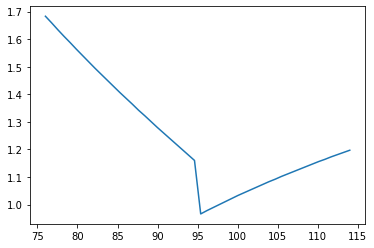

In [27]:
volatility_surface(95,112.5,0.5,0.1,0.25,option="put").vol_smile(market_option=27)

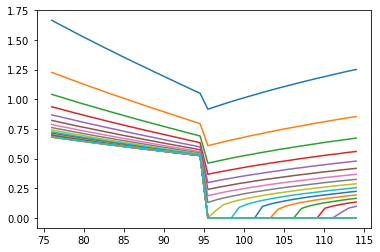

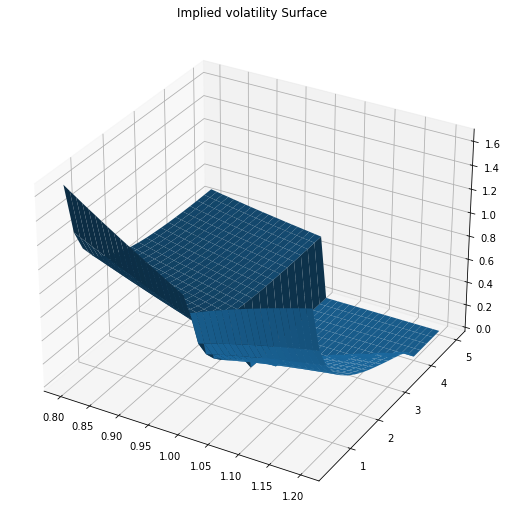

,0.25 years,0.5 years,0.75 years,1.0 years,1.25 years,1.5 years,1.75 years,2.0 years,2.25 years,2.5 years,2.75 years,3.0 years,3.25 years,3.5 years,3.75 years,4.0 years,4.25 years,4.5 years,4.75 years,5.0 years
0,1.667,1.227,1.042,0.937,0.869,0.822,0.788,0.762,7.420000e-01,7.260000e-01,7.140000e-01,7.050000e-01,6.980000e-01,6.920000e-01,6.880000e-01,6.850000e-01,6.830000e-01,6.820000e-01,6.820000e-01,6.820000e-01
1,1.631,1.203,1.022,0.920,0.854,0.808,0.774,0.749,7.300000e-01,7.150000e-01,7.030000e-01,6.940000e-01,6.870000e-01,6.820000e-01,6.780000e-01,6.750000e-01,6.730000e-01,6.730000e-01,6.730000e-01,6.730000e-01
2,1.597,1.178,1.002,0.902,0.838,0.793,0.761,0.737,7.180000e-01,7.040000e-01,6.920000e-01,6.840000e-01,6.770000e-01,6.720000e-01,6.680000e-01,6.660000e-01,6.640000e-01,6.630000e-01,6.640000e-01,6.640000e-01
3,1.562,1.154,0.982,0.885,0.823,0.779,0.748,0.724,7.060000e-01,6.920000e-01,6.820000e-01,6.730000e-01,6.670000e-01,6.620000e-01,6.590000e-01,6.560000e-01,6.550000e-01,6.540000e-01,6.550000e-01,6.560000e-01
4,1.528,1.130,0.962,0.868,0.807,0.765,0.735,0.712,6.950000e-01,6.810000e-01,6.710000e-01,6.630000e-01,6.570000e-01,6.530000e-01,6.490000e-01,6.470000e-01,6.460000e-01,6.460000e-01,6.460000e-01,6.470000e-01
5,1.495,1.106,0.943,0.851,0.792,0.752,0.722,0.700,6.830000e-01,6.710000e-01,6.610000e-01,6.530000e-01,6.470000e-01,6.430000e-01,6.400000e-01,6.380000e-01,6.370000e-01,6.370000e-01,6.370000e-01,6.390000e-01
6,1.461,1.083,0.924,0.835,0.778,0.738,0.710,0.688,6.720000e-01,6.600000e-01,6.500000e-01,6.430000e-01,6.380000e-01,6.340000e-01,6.310000e-01,6.290000e-01,6.290000e-01,6.290000e-01,6.290000e-01,6.300000e-01
7,1.428,1.059,0.905,0.818,0.763,0.725,0.697,0.677,6.610000e-01,6.490000e-01,6.400000e-01,6.340000e-01,6.280000e-01,6.250000e-01,6.220000e-01,6.210000e-01,6.200000e-01,6.200000e-01,6.210000e-01,6.220000e-01
8,1.396,1.036,0.886,0.802,0.749,0.712,0.685,0.665,6.500000e-01,6.390000e-01,6.300000e-01,6.240000e-01,6.190000e-01,6.160000e-01,6.140000e-01,6.120000e-01,6.120000e-01,6.120000e-01,6.130000e-01,6.140000e-01
9,1.363,1.014,0.868,0.786,0.734,0.698,0.673,0.654,6.400000e-01,6.290000e-01,6.210000e-01,6.150000e-01,6.100000e-01,6.070000e-01,6.050000e-01,6.040000e-01,6.030000e-01,6.040000e-01,6.050000e-01,6.060000e-01


In [44]:
volatility_surface(95,112.5,0.5,0.1,0.25,option="put").get_surface(market_option=18)